In [349]:
import torchvision.transforms as transforms
from torchvision.datasets import Cityscapes
from torch.utils.data import Dataset

In [88]:
!rm ./cityscapes/leftImg8bit/train/.*

zsh:1: no matches found: ./cityscapes/leftImg8bit/train/.*


In [330]:
# Cityscapes(split="train", mode="fine", target_type=...)

In [359]:
import os
from PIL import Image


class CustomCityScapes(Dataset):
    def __init__(self, root_dir, split="train", target_type=["semantic"], image_transforms=None, mask_transforms=None):
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        self.target_type = target_type
        # ./cityscapes/leftImg8bit/train/leftImg8bit/train <- mac/linux
        # .\\cityscapes\\leftImg8bit\\train\\leftImg8bit\\train <- windows
        self.images_split_path = os.path.join(root_dir, "leftImg8bit", split)
        self.annot_split_path = os.path.join(root_dir, "gtFine", split)
        
        self.image_paths_only = sorted([os.path.join(dir_path, file) 
                            for city in os.listdir(self.images_split_path) 
                            for dir_path, _, files in os.walk(os.path.join(self.images_split_path, city)) 
                            for file in files])
        
        # "./cityscapes/leftImg8bit/train/zurich/zurich_000069_000019_leftImg8bit.png" -> "zurich_000069_000019"
        self.image_ids = [os.path.split(file)[1].replace("_leftImg8bit.png", "") for file in self.image_paths_only]
        # "zurich_000069_000019": "./cityscapes/leftImg8bit/train/zurich/zurich_000069_000019_leftImg8bit.png"
        self.image_paths = {id_: file for id_, file in zip(self.image_ids, self.image_paths_only)}

        target_type_map = {'semantic': 'labelIds', 'color': 'color', 'polygons': 'polygon', 'instance': 'instanceIds'}
        self.target_type = [target_type_map[target] for target in self.target_type]
        self.annot_paths = list(zip(*[self.get_annotation_paths(type_=type_) for type_ in self.target_type]))


    def __iter__(self):
        for img, annots in zip(self.image_paths, self.annot_paths):
            yield img, annots
    

    def __getitem__(self, index):
        img = Image.open(self.image_paths_only[index])
        annots = [Image.open(target_item_path) for target_item_path in self.annot_paths[index]]

        if self.image_transforms:
            img = self.image_transforms(img)
        
        if self.mask_transforms:
            annots = [self.mask_transforms(annot) for annot in annots]

        return img, annots


    def __repr__(self):
        return "Custom Cityscapes dataset"


    def __len__(self):
        return len(self.image_paths)
        

    def get_source_image_paths(self, id_=False):
        if not id_:
            return self.image_paths
        return self.image_paths[id_]
    

    def get_image(self, id_):
        return Image.open(self.image_paths[id_])


    def get_annotation_paths(self, type_):
        self.annot_path_local = {'polygons': {}, 'color': {}, 'labelIds': {}, 'instanceIds': {}}
        for city in os.listdir(self.annot_split_path):
            for dir_path, _, files in os.walk(os.path.join(self.annot_split_path, city)):
                for file in files:
                    file_path = os.path.join(dir_path, file)
                    file_id, cat = os.path.splitext(os.path.split(file_path)[1].replace('_gtFine_', '|'))[0].split('|')
                    self.annot_path_local[cat][file_id] = file_path
        
        return [self.annot_path_local[type_][id_] for id_ in self.image_ids]


image_transforms = transforms.Compose([
    transforms.Resize((128, 256)),
    transforms.RandomAutocontrast(1),
    # transforms.ToTensor()
])

mask_transforms = transforms.Compose([
    transforms.Resize((128, 256)),
    # transforms.ToTensor()
])

dataset = CustomCityScapes("./cityscapes", split="train", target_type=["color", "semantic"], image_transforms=image_transforms, mask_transforms=mask_transforms)

In [360]:
len(dataset)

2975

In [340]:
# dataset.get_image("zurich_000069_000019")

In [341]:
# im_path_temp = dataset.image_paths["zurich_000069_000019"]
# Image.open(im_path_temp)

In [346]:
im, (color, sem) = dataset[0]

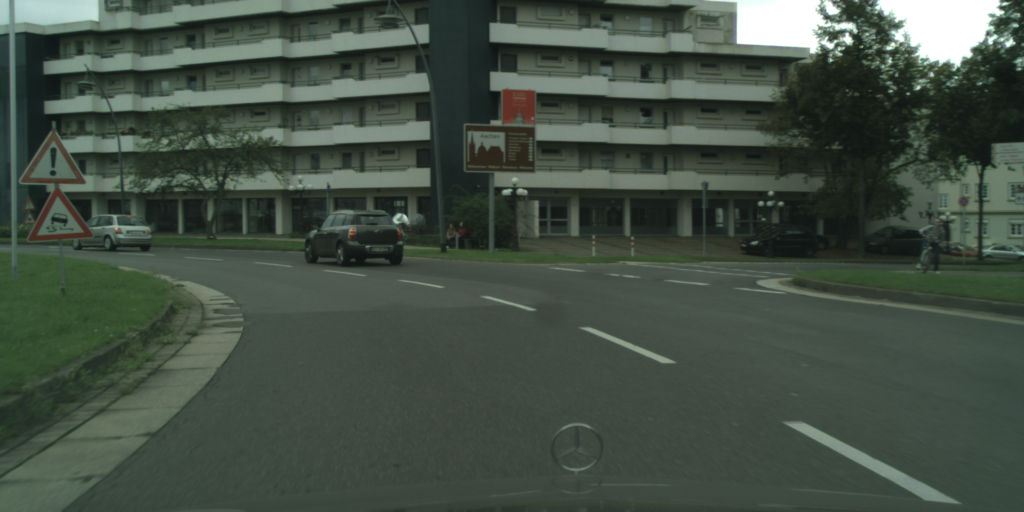

In [347]:
im

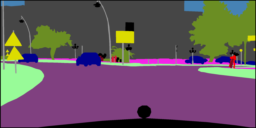

In [348]:
color

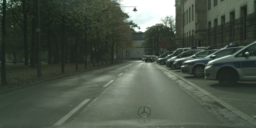

In [318]:
im

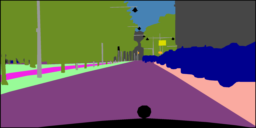

In [319]:
color

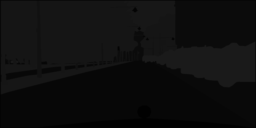

In [320]:
sem